Загрузите из keras.datasets набор данных CIFAR10 small images classification dataset (https://keras.io/api/datasets/cifar10/).

Оставьте в наборе изображения четырех классов предметов с метками, соответствующими четырем разным последним цифрам Вашего студенческого билета (например, если номер студбилета 1032259319, то последние четыре разные цифры – это 1, 3, 5, 9).

Выберите какую-либо размерность латентного пространства, создайте и обучите на обучающей выборке вариационный автокодировщик с размерностью скрытого представления, равной выбранной размерности латентного пространства.

Выберите в наборе данных два изображения разных классов, определите точки в скрытом пространстве, соответствующие этим изображениям, выполните трансформацию между двумя выбранными изображениями и визуализируйте полученные переходные изображения.

In [13]:

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
import math
import random
import matplotlib.pyplot as plt


print(f"TF: {tf.__version__} | Keras: {keras.__version__} | Backend: {keras.backend.backend()}")


TF: 2.19.0 | Keras: 3.10.0 | Backend: tensorflow


In [14]:
# User-configurable hyperparams
STUDENT_DIGITS = [5, 8, 6, 9]
LATENT_DIM = 8
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3
INTERP_STEPS = 12                   # number of frames between A and B (inclusive)
INTERP_MODE = "slerp"               # "lerp" or "slerp"

# two classes for interpolation
CLASS_A = 5
CLASS_B = 9

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# CIFAR-10 label names
CIFAR10_LABELS = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


In [15]:
# Utility functions
def slerp(p0, p1, t, eps=1e-7):
    """Spherical linear interpolation in latent space.
    Falls back to LERP when angle ~ 0.
    """
    p0 = np.asarray(p0, dtype=np.float32)
    p1 = np.asarray(p1, dtype=np.float32)
    p0_norm = p0 / (np.linalg.norm(p0) + eps)
    p1_norm = p1 / (np.linalg.norm(p1) + eps)
    dot = np.clip(np.dot(p0_norm, p1_norm), -1.0, 1.0)
    omega = np.arccos(dot)
    if np.abs(omega) < 1e-3:
        return (1.0 - t) * p0 + t * p1
    so = np.sin(omega)
    return np.sin((1.0 - t) * omega) / so * p0 + np.sin(t * omega) / so * p1


def lerp(p0, p1, t):
    """Linear interpolation in latent space."""
    return (1.0 - t) * np.asarray(p0) + t * np.asarray(p1)


def make_grid(images, n_cols=8, titles=None, suptitle=None, w=2.0, h=2.0):
    """Plot a grid of images."""
    images = np.asarray(images)
    n = len(images)
    n_cols = min(n_cols, n)
    n_rows = int(np.ceil(n / n_cols))
    plt.figure(figsize=(w * n_cols, h * n_rows))
    for i in range(n):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(images[i])
        ax.axis("off")
        if titles is not None and i < len(titles) and titles[i] is not None:
            ax.set_title(titles[i], fontsize=9)
    if suptitle:
        plt.suptitle(suptitle, y=0.98)
    plt.tight_layout()
    plt.show()


def to_float01(x):
    """Convert uint8 images to float32 in [0,1]."""
    return x.astype("float32") / 255.0


def pick_first_by_label(x, y, label):
    """Return the first image with a given label."""
    idx = np.where(y == label)[0]
    if len(idx) == 0:
        raise ValueError(f"No sample found with label={label}")
    return x[idx[0]]



In [17]:
# Load & filter CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Filter to selected classes (digits)
def filter_classes(x, y, keep):
    mask = np.isin(y, keep)
    return x[mask], y[mask]

x_train_f, y_train_f = filter_classes(x_train, y_train, STUDENT_DIGITS)
x_test_f, y_test_f  = filter_classes(x_test,  y_test,  STUDENT_DIGITS)

print("Train filtered:", x_train_f.shape, y_train_f.shape)
print("Test  filtered:", x_test_f.shape,  y_test_f.shape)

# Normalize to [0,1]
x_train_f = to_float01(x_train_f)
x_test_f = to_float01(x_test_f)

# Simple train/val split from train_f (90/10)
n = len(x_train_f)
perm = np.random.permutation(n)
split = int(0.9 * n)
train_idx, val_idx = perm[:split], perm[split:]
x_tr, x_val = x_train_f[train_idx], x_train_f[val_idx]
y_tr, y_val = y_train_f[train_idx], y_train_f[val_idx]

# Build tf.data datasets (labels unused for VAE training)
train_ds = tf.data.Dataset.from_tensor_slices(x_tr).shuffle(4096, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(x_val).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Show class counts for sanity
def class_counts(y):
    counts = {d: int((y == d).sum()) for d in sorted(set(y))}
    return {f"{d} ({CIFAR10_LABELS[d]})": c for d, c in counts.items()}
print("Train class counts:", class_counts(y_tr))
print("Val   class counts:", class_counts(y_val))
print("Test  class counts:", class_counts(y_test_f))


Train filtered: (20000, 32, 32, 3) (20000,)
Test  filtered: (4000, 32, 32, 3) (4000,)
Train class counts: {'5 (dog)': 4491, '6 (frog)': 4489, '8 (ship)': 4497, '9 (truck)': 4523}
Val   class counts: {'5 (dog)': 509, '6 (frog)': 511, '8 (ship)': 503, '9 (truck)': 477}
Test  class counts: {'5 (dog)': 1000, '6 (frog)': 1000, '8 (ship)': 1000, '9 (truck)': 1000}


In [19]:
# Build VAE (Conv encoder/decoder)
# Encoder
def build_encoder(latent_dim=LATENT_DIM, input_shape=(32, 32, 3)):
    """Convolutional encoder producing z_mean, z_log_var, and sampled z."""
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # downsampling conv blocks
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)   # 16x16
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)   # 8x8
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)  # 4x4
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Reparameterization trick
    def sampling(args):
        z_m, z_lv = args
        eps = tf.random.normal(shape=tf.shape(z_m))
        return z_m + tf.exp(0.5 * z_lv) * eps

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    return keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
def build_decoder(latent_dim=LATENT_DIM, output_shape=(32, 32, 3)):
    """Convolutional decoder that maps z -> x_hat in [0,1]."""
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 128, activation="relu")(latent_inputs)
    x = layers.Reshape((4, 4, 128))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)  # 8x8
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)   # 16x16
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)   # 32x32
    outputs = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(latent_inputs, outputs, name="decoder")

encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)

# Custom VAE model with explicit loss reporting
class VAE(keras.Model):
    """VAE model that handles KL + reconstruction losses in train/test_step."""
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker    = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        x = data  # data is images only
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)

            # Reconstruction loss (MSE sum over pixels), averaged over batch
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1, 2, 3]))

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            total = recon_loss + kl_loss

        grads = tape.gradient(total, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        x = data
        if isinstance(x, tuple):
            x = x[0]
        z_mean, z_log_var, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1, 2, 3]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total = recon_loss + kl_loss
        self.total_loss_tracker.update_state(total)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [20]:
# Train
history = vae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/10
141/141 - 89s - 629ms/step - kl_loss: 4.8104 - loss: 159.0787 - recon_loss: 154.2683 - val_kl_loss: 8.2439 - val_loss: 126.3577 - val_recon_loss: 118.1139
Epoch 2/10
141/141 - 142s - 1s/step - kl_loss: 11.1903 - loss: 102.0919 - recon_loss: 90.9016 - val_kl_loss: 11.5080 - val_loss: 96.0340 - val_recon_loss: 84.5260
Epoch 3/10
141/141 - 134s - 951ms/step - kl_loss: 11.4078 - loss: 94.8011 - recon_loss: 83.3933 - val_kl_loss: 11.3436 - val_loss: 93.2746 - val_recon_loss: 81.9310
Epoch 4/10
141/141 - 74s - 527ms/step - kl_loss: 11.9832 - loss: 91.8405 - recon_loss: 79.8573 - val_kl_loss: 12.6454 - val_loss: 90.3489 - val_recon_loss: 77.7035
Epoch 5/10
141/141 - 74s - 527ms/step - kl_loss: 12.2456 - loss: 89.6006 - recon_loss: 77.3549 - val_kl_loss: 12.6252 - val_loss: 88.9898 - val_recon_loss: 76.3646
Epoch 6/10
141/141 - 76s - 537ms/step - kl_loss: 12.3630 - loss: 88.8623 - recon_loss: 76.4993 - val_kl_loss: 12.2501 - val_loss: 88.8979 - val_recon_loss: 76.6478
Epoch 7/10
141

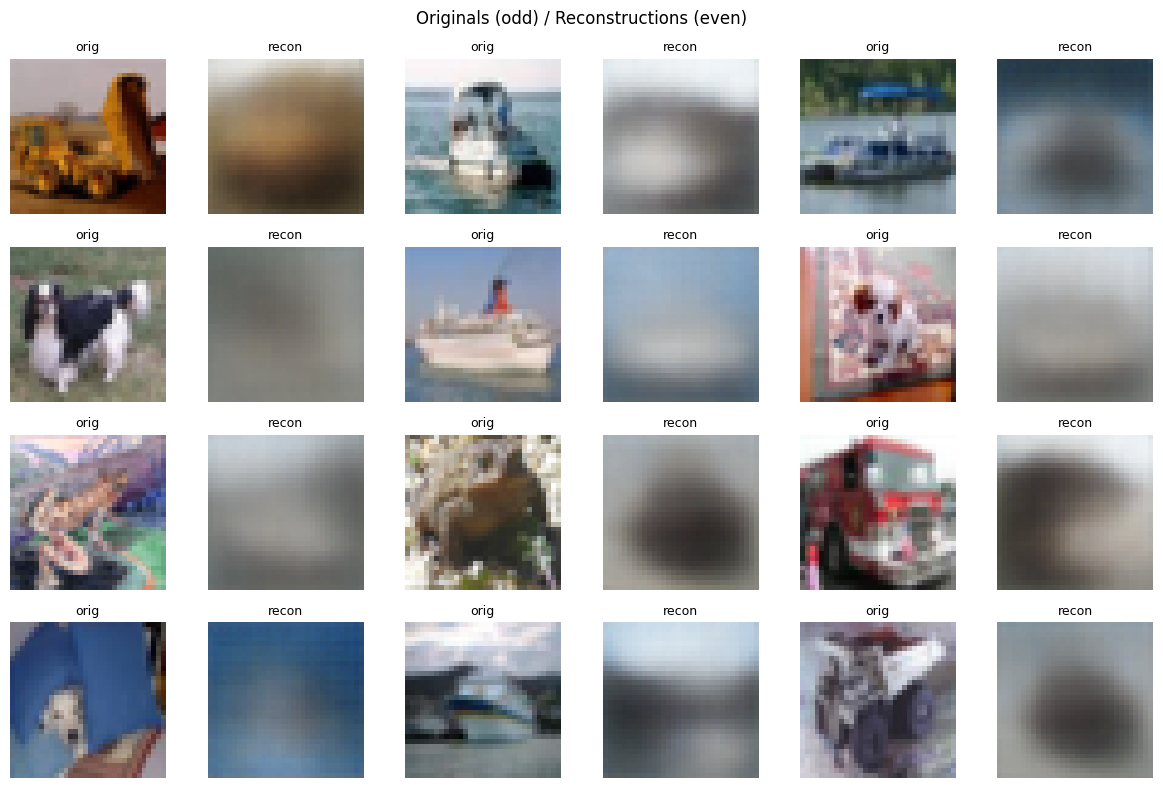

In [21]:
# Reconstructions on test set
n_show = 12
idx = np.random.choice(len(x_test_f), size=n_show, replace=False)
x_sample = x_test_f[idx]
z_mean, z_log_var, z = encoder.predict(x_sample, verbose=0)
x_recon = decoder.predict(z, verbose=0)

# Clip for safety
x_recon = np.clip(x_recon, 0.0, 1.0)

# Interleave originals and reconstructions for visualization
pairs = []
titles = []
for i in range(n_show):
    pairs.append(x_sample[i])
    titles.append(f"orig")
    pairs.append(x_recon[i])
    titles.append(f"recon")
make_grid(pairs, n_cols=6, titles=titles, suptitle="Originals (odd) / Reconstructions (even)")


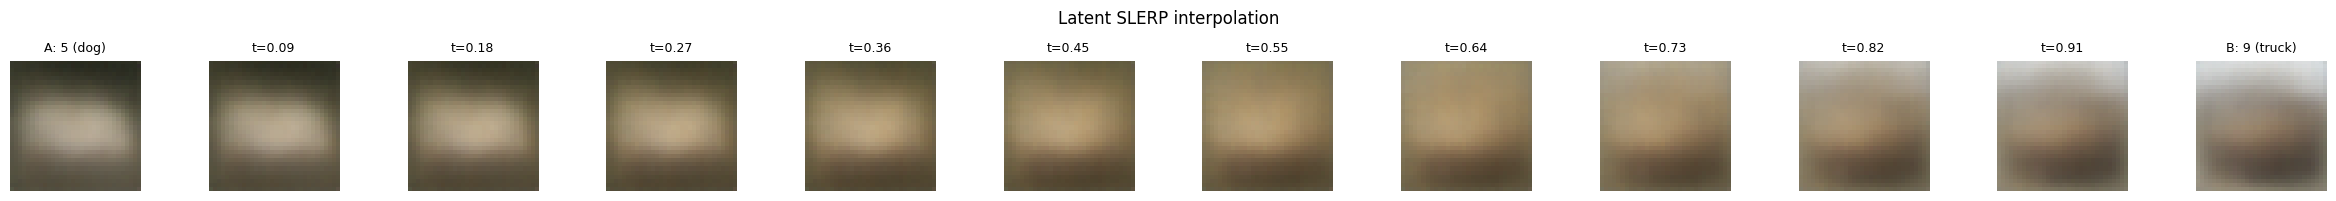

In [23]:

# Latent interpolation between two images of different classes
if CLASS_A not in STUDENT_DIGITS or CLASS_B not in STUDENT_DIGITS or CLASS_A == CLASS_B:
    raise ValueError("CLASS_A and CLASS_B must be two distinct values from STUDENT_DIGITS.")

img_a = pick_first_by_label(x_test_f, y_test_f, CLASS_A)
img_b = pick_first_by_label(x_test_f, y_test_f, CLASS_B)

# Encode to latent means (we use mean for deterministic interpolation)
z_mean_a, _, _ = encoder.predict(img_a[None, ...], verbose=0)
z_mean_b, _, _ = encoder.predict(img_b[None, ...], verbose=0)
za = z_mean_a[0]
zb = z_mean_b[0]

# Build interpolation path
ts = np.linspace(0.0, 1.0, INTERP_STEPS)
zs = []
for t in ts:
    if INTERP_MODE.lower() == "slerp":
        zt = slerp(za, zb, t)
    else:
        zt = lerp(za, zb, t)
    zs.append(zt)
zs = np.stack(zs, axis=0)

# Decode sequence
interp_imgs = decoder.predict(zs, verbose=0)
interp_imgs = np.clip(interp_imgs, 0.0, 1.0)

# Show interpolation with endpoints labeled
titles = [f"t={t:.2f}" for t in ts]
titles[0] = f"A: {CLASS_A} ({CIFAR10_LABELS[CLASS_A]})"
titles[-1] = f"B: {CLASS_B} ({CIFAR10_LABELS[CLASS_B]})"
make_grid(interp_imgs, n_cols=INTERP_STEPS, titles=titles, suptitle=f"Latent {INTERP_MODE.upper()} interpolation")


In [24]:

# Op: 2D latent scatter if LATENT_DIM == 2
if LATENT_DIM == 2:
    print("LATENT_DIM == 2 → projecting test set means...")
    # Take a subset for speed
    max_pts = min(3000, len(x_test_f))
    x_sub = x_test_f[:max_pts]
    y_sub = y_test_f[:max_pts]
    z_means, _, _ = encoder.predict(x_sub, verbose=0)
    # Basic scatter
    plt.figure(figsize=(6, 5))
    for d in sorted(set(y_sub)):
        mask = (y_sub == d)
        plt.scatter(z_means[mask, 0], z_means[mask, 1], s=8, alpha=0.7, label=f"{d}:{CIFAR10_LABELS[d]}")
    plt.legend(markerscale=2, fontsize=8)
    plt.title("Latent space (z_mean) by class")
    plt.xlabel("z1"); plt.ylabel("z2")
    plt.tight_layout()
    plt.show()

print("Done.")


Done.
